In [175]:
import sys
sys.path.insert(0, '/Users/kerong/')
from helper import *

import warnings
warnings.filterwarnings("ignore")

import os
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
plotly.tools.set_credentials_file(username='keryums', api_key='G5YsVJOebOZh0nhwk44q')

import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [176]:
data_filepath = '/Users/kerong/data/veteran_suicide/data_out/'

In [177]:
for filename in glob.glob(os.path.join(data_filepath, '*.csv')):
    print(filename)

/Users/kerong/data/veteran_suicide/data_out/state_by_age_wide_20190117_1624.csv
/Users/kerong/data/veteran_suicide/data_out/va_spend_2016_20190117_1650.csv
/Users/kerong/data/veteran_suicide/data_out/state_by_method_20190117_1648.csv
/Users/kerong/data/veteran_suicide/data_out/state_by_sex_wide_20190117_1620.csv


In [179]:
state_by_age = pd.read_csv('/Users/kerong/data/veteran_suicide/data_out/state_by_age_wide_20190117_1624.csv')
state_by_sex = pd.read_csv('/Users/kerong/data/veteran_suicide/data_out/state_by_sex_wide_20190117_1620.csv')
state_by_method = pd.read_csv('/Users/kerong/data/veteran_suicide/data_out/state_by_method_20190117_1648.csv')

# Suicides by Sex

## Comparison of Rates

Since each 10 count bin is indicated by its lower bound, let's estimate a point estimate for each state using the bin's mean/median.

In [180]:
suicides_by_sex = state_by_sex.groupby('sex')['suicides_point_est'].sum().reset_index()
suicides_by_sex

,sex,suicides_point_est
0,Female,106.0
1,Male,5779.0


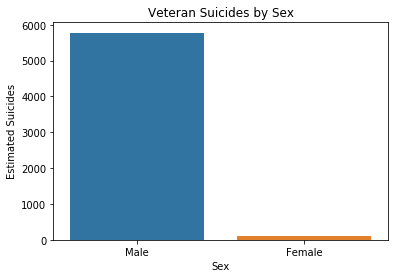

In [181]:
suicides_by_sex.sort_values(by='sex', ascending=False, inplace=True) #sort for plotting 
ax = sns.barplot(x='sex', y='suicides_point_est', data = suicides_by_sex[~(suicides_by_sex.sex=='Total')])
ax.set_title('Veteran Suicides by Sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Estimated Suicides')
plt.show()

__Notice the disparity in suicides by gender. Is this wholly explicable by differences in the number of male and female veterans?__

As the VA did not publish suicide rates by gender (unlike it does for the other attributes, age and suicide method), let's calculate this by pulling in a veteran population table. We consider population figures as of September 2015 since this is the population from which suicides in 2016 occurred. 

In [187]:
total_by_sex = state_by_sex.groupby('sex')['veterans'].sum().reset_index()
total_by_sex

,sex,veterans
0,Female,63642419.0
1,Male,421985510.0


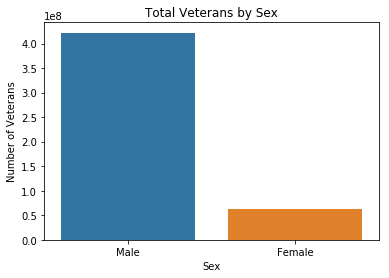

In [183]:
total_by_sex.sort_values(by='sex', ascending=False, inplace=True) #sort for plotting 
ax = sns.barplot(x='sex', y='veterans', data = total_by_sex)
ax.set_title('Total Veterans by Sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Number of Veterans')
plt.show()

__Is the proportion the same?__

In [184]:
counts_by_sex = state_by_sex.groupby('sex')[['suicides_point_est', 'veterans']].sum().reset_index()
rate_by_sex = counts_by_sex[['suicides_point_est', 'veterans']].apply(lambda x: x[0]/x[1], axis=1).reset_index()
sex_map = {0:'female',1:'male'} 
rate_by_sex.replace({'index': sex_map}, inplace=True)
rate_by_sex.rename(columns = {'index':'sex', 0:'rate'}, inplace=True)

In [185]:
rate_by_sex

,sex,rate
0,female,0.000002
1,male,0.000014


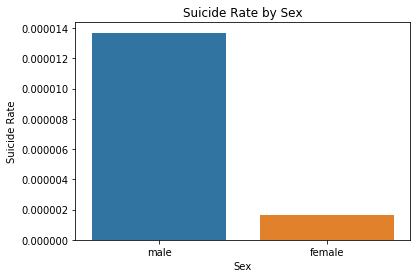

In [186]:
rate_by_sex.sort_values(by='sex', ascending=False, inplace=True) #sort for plotting 
ax = sns.barplot(x='sex', y='rate', data = rate_by_sex)
ax.set_title('Suicide Rate by Sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Suicide Rate')
plt.show()

The chart above shows a different in rates of suicide between male and female veterans. Let's formalize this with a test of proportions to see if the difference in rates are statistically significantly.

In [190]:
count = np.array(counts_by_sex.suicides_point_est)
nobs = np.array(counts_by_sex.veterans)
stat, pval = proportions_ztest(count,nobs)

print('p-value of test: {0:0.3f}'.format(pval))

p-value of test: 0.000


According to our statistical test, we fail to reject the hypothesis that there is a significant difference between rates of suicide for male and female veterans. We can extrapolate from this that gender is a differentiating factor in suicide occurrence.

## Map of Rates

In [192]:
# suicide rate per state
state_by_sex['suicide_rate']=state_by_sex[['suicides_point_est', 'veterans']].apply(lambda x: x[0]/x[1], axis=1)

In [205]:
state_rates=state_by_sex.groupby('state_code')[['suicides_point_est', 'veterans']].sum().reset_index()

In [208]:
state_rates['suicide_rate'] = state_rates.suicides_point_est/state_rates.veterans

In [220]:
data = [ dict(type='choropleth',
              colorscale='Viridis',
              autocolorscale=False,
              locations=state_rates['state_code'],
              z=state_rates['suicide_rate'],
              locationmode = 'USA-states'
             )
       ]

layout = dict(title = 'Plot of Suicide Rates by State ',
             geo = dict(scope='usa',
                       projection=dict(type='albers usa'),
                       showlakes=True,
                       lakecolor='rgb(255,255,255)'))

fig = dict(data=data, layout=layout)

In [221]:
py.iplot(fig, filename='d3-choropleth-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~keryums/0 or inside your plot.ly account where it is named 'd3-choropleth-map'


Vermont has the highest suicide rate of .0025%, 1.3% higher than the next highest states Montana, Nevada, and Wyoming, which each come in at 0.0019%. Notice that the western US generally has higher rates than the eastern US. Could higher rates be associated with worse VA facilities in those areas? 

Let's analyze some VA expenditure data:

## Expenditure Data

In [201]:
va_spend_2016 = pd.read_csv(data_filepath+'va_spend_2016_20190114_2148.csv')

FileNotFoundError: File b'/Users/kerong/data/veteran_suicide/data_out/va_spend_2016_20190114_2148.csv' does not exist

In [124]:
display_all(va_spend_2016.head())

,state,veteran_population,total_expenditure,compensation_&_pension,construction,education_&_vocational_rehabilitation_employment,loan_guaranty,general_operating_expenses,insurance_&_indemnities,medical_care,unique_patients
0,Alabama,373761.35,3429322.81,2062094.31,2559.63,219849.80,0.0,38702.80,25449.49,1080666.78,112993.0
1,Alaska,68436.26,639118.75,280603.31,498.07,76517.96,0.0,26627.27,2347.29,252524.85,20037.0
2,Arizona,515050.15,3919748.59,1833525.23,26069.14,386087.44,0.0,69949.70,36076.08,1568041.00,151910.0
3,Arkansas,225117.59,2215940.44,1129084.13,13395.87,89670.25,0.0,28243.81,14433.29,941113.09,86483.0
4,California,1735212.60,15568594.92,7252271.47,171912.75,1861299.79,0.0,196187.34,153142.88,5933780.68,466638.0


Let's normalize total expenditure by number of patients:

In [132]:
va_spend_2016['total_spend_per_vet'] = va_spend_2016.total_expenditure/va_spend_2016.veteran_population

In [127]:
va_spend_2016['total_spend_per_patient'] = va_spend_2016.total_expenditure/va_spend_2016.unique_patients

In [133]:
va_spend_2016.head()

,state,veteran_population,total_expenditure,compensation_&_pension,construction,education_&_vocational_rehabilitation_employment,loan_guaranty,general_operating_expenses,insurance_&_indemnities,medical_care,unique_patients,total_spend_per_patient,total_spend_per_vet
0,Alabama,373761.35,3429322.81,2062094.31,2559.63,219849.80,0.0,38702.80,25449.49,1080666.78,112993.0,30.349870,9.175167
1,Alaska,68436.26,639118.75,280603.31,498.07,76517.96,0.0,26627.27,2347.29,252524.85,20037.0,31.896928,9.338891
2,Arizona,515050.15,3919748.59,1833525.23,26069.14,386087.44,0.0,69949.70,36076.08,1568041.00,151910.0,25.803098,7.610421
3,Arkansas,225117.59,2215940.44,1129084.13,13395.87,89670.25,0.0,28243.81,14433.29,941113.09,86483.0,25.622844,9.843480
4,California,1735212.60,15568594.92,7252271.47,171912.75,1861299.79,0.0,196187.34,153142.88,5933780.68,466638.0,33.363324,8.972154


In [143]:
va_spend_2016.loc[va_spend_2016['state'] == 'District of Columbia', 'state']  = 'District Of Columbia' #change to match dictionary

In [147]:
va_spend_2016 = va_spend_2016[~va_spend_2016.state.isin(['Puerto Rico', 'Guam'])] #exclude from this analysis 

In [150]:
va_spend_2016['state_code'] = va_spend_2016.state.apply(lambda x : state_codes[x])

In [154]:
va_spend_2016.head()

,state,veteran_population,total_expenditure,compensation_&_pension,construction,education_&_vocational_rehabilitation_employment,loan_guaranty,general_operating_expenses,insurance_&_indemnities,medical_care,unique_patients,total_spend_per_patient,total_spend_per_vet,state_code
0,Alabama,373761.35,3429322.81,2062094.31,2559.63,219849.80,0.0,38702.80,25449.49,1080666.78,112993.0,30.349870,9.175167,AL
1,Alaska,68436.26,639118.75,280603.31,498.07,76517.96,0.0,26627.27,2347.29,252524.85,20037.0,31.896928,9.338891,AK
2,Arizona,515050.15,3919748.59,1833525.23,26069.14,386087.44,0.0,69949.70,36076.08,1568041.00,151910.0,25.803098,7.610421,AZ
3,Arkansas,225117.59,2215940.44,1129084.13,13395.87,89670.25,0.0,28243.81,14433.29,941113.09,86483.0,25.622844,9.843480,AR
4,California,1735212.60,15568594.92,7252271.47,171912.75,1861299.79,0.0,196187.34,153142.88,5933780.68,466638.0,33.363324,8.972154,CA


In [165]:
va_spend_2016.total_spend_per_patient.unique()

array([ 30,  32,  26,  33,  35,  25,  27, 310,  36,  21,  22,  19,  24,
        29,  23,  28,  34,  31,  37])

In [157]:
va_spend_2016.total_spend_per_patient = va_spend_2016.total_spend_per_patient.apply(lambda x : round(x))
va_spend_2016.total_spend_per_vet = va_spend_2016.total_spend_per_vet.apply(lambda x : round(x))

In [161]:
va_spend_2016.dtypes

state                                                object
veteran_population                                  float64
total_expenditure                                   float64
compensation_&_pension                              float64
construction                                        float64
education_&_vocational_rehabilitation_employment    float64
loan_guaranty                                       float64
general_operating_expenses                          float64
insurance_&_indemnities                             float64
medical_care                                        float64
unique_patients                                     float64
total_spend_per_patient                               int64
total_spend_per_vet                                   int64
state_code                                           object
dtype: object

In [166]:
m = folium.Map(location=[48,-102], zoom_start=3)

folium.Choropleth(geo_data=state_geo,
             name='choropleth',
             data=va_spend_2016,
             columns=['state_code', 'total_spend_per_patient'],
             key_on='feature.id',
             fill_color='YlGn',
             fill_opacity=0.7,
             line_opacity=0.2,
             legend_name='Total Spend per Patient').add_to(m)

folium.LayerControl().add_to(m)

m

# TROUBLESHOOT NOT RENDERING COLOR FOR SPEND_PER_VET OR SPEND_PER_PATIENT

# Suicides by Age

TO DO:
* Remove '<' and '-' (ranges) from veteran_suicides and general_population_suicides 
* Remove '--', '*' from rate columns 

# Suicides by Method

TO DO:
* Remove ',', '<', from suicides
* Replace '--' from group_percentage 